    1. будем тестировать на последнем месяце с дообучением. т.е обучаем на :t-30 делаем прогноз на t-30, после на :t-29 прогноз на t-29,... и считаем так mae! -->
    2. детектируем аномалии ряда и разладку. модель будет выдавать прогноз и индикатор разладки, 
    3. таким образом mae считаем только на данных без аномалии и делаем refit с theta разладки, если изменилась ts
    4. фитим параметры sarimax на данных без аномалий и с периода разладки (default=0)
    5. с помощью tsfresh генерим фичи
    6. далее комб алгоритмом фильтруме фичи и делаем тест на стабильность (используем только sarimax) [важность фичей определяем по val1, как базы для бустинга!]
    7. при этом трейн давайте разобьем на трейн и валидацию для генерирования метафичей. т. е. на трейне подобрали гиперпараметры sarimax, garch: p, d, q, etc. 
    8. далее их зафиксировали, на валидации сделали прогноз таргета на первый день, дообучили с фикс p,d,q, ... сделали след прогноз. далее на тесте тоже самое напредиктили
    9. получили на val balance_predicted (sarimax)
    10. теперь бустингом попробуем сделать поправку к прогнозам
    11. разобьем валидацию на две части val_boost_train, val_boost_test. подберем гиперпараметры на коэффы
    12. с фикс гиперпараметрами сделаем рефит бустинга на val и уже рефитнутым бустингом с sarimax + garch прогнозим тест
    13. при этом на тесте mae не считаем по аномалиям

# Import 

In [1068]:
import pandas as pd
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json
import scipy
import statsmodels.api as sm
from joblib import Parallel, delayed
import os
from os.path import join
import utils
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
import requests
from itertools import product
plt.rcParams.update({'figure.figsize': (10, 5), 'figure.dpi': 100})
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import stability as st
from sklearn import linear_model
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from scipy.stats import norm

# Create config

In [202]:
config = {
    "data": {"path": "../data/Project 1_2024.xlsx",
            "sheet_name": "Data",
             "path_to_calendar": '../data/calendar.json',
             "key_rate_path": '../data/keyrate.csv',
             "key_rate_date_col": "date"
            },
        
    "features": {
    "target_col": "Balance",
    "date_col": "Date",
    },
    
    "analytics": {"show_analytics": False,
                  "path": "../result/analytics"},
    
    "train_params": {"train_val": 0.5, "val_boost_ratio": 0.7,  "test_size": 30}
    
    
}
with open('../config/config.json', 'w') as f:
    json.dump(config, f)

In [902]:
class TSForecastingPipeline():
    def __init__(self, config_path: str = "../config/config.json", debug: bool = True):
        self.debug = debug
        self._config_path = config_path
        self.config = self._load_config()
        print(self.config) if self.debug else None
        
        self.path_to_data = self.config["data"]["path"]
        self.sheet_name = self.config["data"]["sheet_name"]
        self.target_col = self.config["features"]["target_col"]
        self.date_col = self.config["features"]["date_col"]
        
        self.path_to_calendar = self.config["data"]["path_to_calendar"]
        self.key_rate_path = self.config["data"]["key_rate_path"]
        self.key_rate_date_col = self.config["data"]["key_rate_date_col"]
        
        
        self.data = self._load_data()
        self.data.index = pd.DatetimeIndex(self.data.index.values,
                               freq=self.data.index.inferred_freq)
        self.data.index.name = "Date"
        
        self.target = self.data[self.target_col]
        
        self.train_params = self.config["train_params"]
        self.train_val = self.config["train_params"]["train_val"]
        self.val_boost_ratio = self.config["train_params"]["val_boost_ratio"]
        self.test_size = self.config["train_params"]["test_size"]
        
        self.show_analytics = self.config["analytics"]["show_analytics"]
        self.analytics_path = self.config["analytics"]["path"]
        if self.show_analytics:
            self.ts_analysis(self.target)
        
        self.data_with_custom = self.add_custom_features(self.data, self.target_col)
        self.data_with_ts_and_custom = self.add_ts_features(self.data_with_custom, self.target_col)
        self.data_preproced = pipe.data_with_ts_and_custom.dropna()
        
        (self.X_trainval, self.y_trainval, 
        self.X_test, self.y_test,
        self.X_train, self.y_train, 
        self.X_val, self.y_val,
        self.X_val_boost_train,
        self.y_val_boost_train,
        self.X_val_boost_test, self.y_val_boost_test) = self.train_test_split(self.data_preproced, self.train_val, self.val_boost_ratio, self.test_size, self.target_col)
        
        
        
        self.sarimax_searcher = SarimaxSearcher()
        #fit p, d, q, P, D, Q
        best_params, best_df = self.sarimax_searcher.hyperopt_search(self.y_train)

        #sliding, one-out window prediction for feature estimation and fitting boosting
        self.pred_trainval, _ = self.sarimax_searcher.fit_predict_trainval(self.y_train, self.y_val)

        self.sarimax_result = pd.concat([self.pred_trainval, self.y_trainval], axis=1)
        self.sarimax_result.columns=["y_pred",  "y_true"]

        self.MAE_VAL = (self.sarimax_result["y_pred"] - self.sarimax_result["y_true"]).iloc[len(self.y_train):].abs().mean()

        print(f"Extending train, one out MAE for validation: {self.MAE_VAL:.02f}")
                              
    def _load_config(self):
        """
        load json config from self._config_path with paths, etc. and return it
        """
        with open(self._config_path) as f:
            config = json.load(f) 
        return config
    
    def _load_data(self):
        """
        load dataset from excel and return it
        """
        
        assert os.path.isfile(self.path_to_data), f"No such data file with path {self.path_to_data}"
        data = pd.read_excel(self.path_to_data,
                             sheet_name=self.sheet_name, 
                             parse_dates=[self.date_col], 
                             index_col=self.date_col)
        data = data[[self.target_col]]
        data = data.sort_index()
        return data
    
    def ts_analysis(self, y, save_fig=True, label="default"):
        """
        plot ts analytics for y ts vatiable with datetime index
        show it and save if save_fig to self.analytics_path/label dir
        """
        if not os.path.exists(join(self.analytics_path, label)):
            os.mkdir(join(self.analytics_path, label))       
        fig = y.plot()
        fig.set_title("target_dynamic " + f"Stationarity = {utils.stationarity_check(y)}")
        plt.savefig(join(self.analytics_path, label, "target_dynamic.png"))
        plt.show()
        fig = y.hist(bins=30)
        fig.set_title("target_distribution " + f"Normaltest = {scipy.stats.normaltest(y)}")
        plt.savefig(join(self.analytics_path, label, "target_distribution.png"))
        plt.show()
        
        fig = np.cumsum(y).plot()
        fig.set_title("CUSUM")
        plt.savefig(join(self.analytics_path, label, "cusum.png"))
        fig = utils.tsplot(y)
        fig.savefig(join(self.analytics_path, label, "tsplot.png"))
        fig = utils.plot_decomposition(y)
        fig.savefig(join(self.analytics_path, label, "additive_decomposition.png"))

        
    
    def add_ts_features(self, data, target_col):
        """
        use tsfresh to extact ts stat features with window 30 (drop first date to avoid leakage)
        """
        print("Adding TS features") if self.debug else None
        df = data.copy()[[target_col]]
        df["Dummy_id"] = 0
        df = df.reset_index()
        df_rolled = roll_time_series(df, column_id="Dummy_id", column_sort="Date",
                                     max_timeshift=30, min_timeshift=0, n_jobs=10) #closed-right interval, so we should do a shift

        df = extract_features(df_rolled.drop("Dummy_id", axis=1), 
                             column_id="id", column_sort="Date", column_value="Balance", 
                             impute_function=impute, show_warnings=False, n_jobs=10)


        df = df.set_index(df.index.map(lambda x: x[1]), drop=True)

        df.index.name = "Date"

        df = df.shift(1) #!no leak
        df = pd.concat([data.copy(), df], axis=1)
        return df
    
    def add_custom_features(self, data, target_col):
        """
        add features from feature engeneering.ipynb, so that's calendar features, lags, also rolling stats, key rate value(it was considered that we know tha value on t-1), tax days
        """
        print("Adding CUSTOM features") if self.debug else None
        df = data.copy()[[target_col]]
        df = self.add_calendar_feats(df)
        df = self.add_key_rate(df)
        df = self.add_rollings_and_lags(df, target_col)
        df = self.add_payday(df)
        df = pd.concat([data.copy().drop(columns=target_col), df], axis=1)
        return df
    
    def add_calendar_feats(self, df):
        print("Adding CALENDAR features") if self.debug else None
        df = df.copy()
        
        #calendar features
        df['weekend'] = np.where(df.index.weekday > 4, 1, 0)

        df['day_of_week'] = df.index.weekday

        day_of_week_columns = pd.get_dummies(df['day_of_week'], dtype=int)
        day_of_week_columns.columns = ["Monday", "Tuesday", "Wednesday", "Thursday", "Firday", "Saturday", "Sunday"]

        df = df.merge(day_of_week_columns, left_index=True, right_index=True)


        df['day_of_week_sin'] = np.sin(df['day_of_week'] * (2 * np.pi / 7))
        df['day_of_week_cos'] = np.cos(df['day_of_week'] * (2 * np.pi / 7))


        with open(self.path_to_calendar) as f:
            calendar = json.load(f) 

        calendar = {k: pd.to_datetime(v) for k, v in calendar.items()}

        df["holiday"] = df.index.isin(calendar["holidays"].union(calendar["nowork"])).astype(int)

        df["preholiday"] = df.index.isin(calendar["preholidays"]).astype(int)


        month = pd.get_dummies(df.index.month,prefix='month', dtype=int).set_index(df.index)

        quarter = pd.get_dummies(df.index.quarter,prefix='quarter', dtype=int).set_index(df.index)

        df = pd.concat([df, month, quarter],axis=1)
        
        df.drop(columns=["day_of_week"], inplace=True)

        return df
    
    def add_key_rate(self, df: pd.DataFrame):
        print("Adding KEY_RATE features") if self.debug else None
        df = df.copy()
        keyrate = pd.read_csv(self.key_rate_path, 
                              index_col=self.key_rate_date_col, 
                              parse_dates=[self.key_rate_date_col])

        keyrate.columns = ["keyrate"] #MAST HAVE SHIFT

        df = df.join(keyrate, on=df.index)

        df["keyrate"] = df["keyrate"].ffill() #cant'bfill
        
        return df
    
    def add_rollings_and_lags(self, data, target_col):
        """
        input: pd.DataFrame with only target and date index
        """
        print("Adding roll&lags features") if self.debug else None
        df = data.copy()[[target_col]]
        
        rolling_weekly = df[target_col].rolling(7).agg(['mean','std','median','max','min']).shift()
        rolling_weekly.columns = ["Balance_" + col + "_weekly" for col in rolling_weekly.columns]

        rolling_monthly = df[target_col].rolling(30).agg(['mean','std','median','max','min']).shift()
        rolling_monthly.columns = ["Balance_" + col + "_monthly" for col in rolling_monthly.columns]
        # we lose first 30 rows as we do this
        df = pd.concat([data.copy(), rolling_weekly, rolling_monthly], axis=1)

        df["first_lag"] = df.Balance.shift(1)
        df["second_lag"] = df.Balance.shift(2)
        return df
    
    def add_payday(self, df):
        df = df.copy()
        # Initialize target feature column
        df['payday'] = 0

        # Iterate over each row in the DataFrame
        for index, data in df.iterrows():
            if index.day in [15, 25, 28]:
                # Check if weekend, holiday, and target feature are all zero
                if data['weekend'] == 0 and data['holiday'] == 0:
                    data['payday'] = 1
                else:
                    loc = df.index.get_loc(index)
                    # If any of weekend, holiday, or target feature is 1, find the upper row where all are zero
                    lower_row_index = loc - 1
                    loc = df.index[lower_row_index]
                    while lower_row_index > -1 and (df.loc[loc, 'weekend'] == 1 or df.loc[loc, 'holiday'] == 1):
                        lower_row_index -= 1
                        loc = df.index[lower_row_index]
                    df.at[loc, "payday"] = 1

        return df
    
    
    def train_test_split(self, data, train_val_ratio, val_boost_ratio, test_size, target_col):
        """
        return X_trainval, y_trainval, X_test, y_test, X_train, y_train, X_val, y_val, X_val_boost_train, y_val_boost_train, X_val_boost_test, y_val_boost_test
        """
        df = data.copy()

        test = df.iloc[-test_size:]
        trainval = df.iloc[:-test_size]

        trainval_size = trainval.shape[0]
        train_size = int(trainval_size * train_val_ratio) #for hyperparams sarimax
        val_size = trainval_size - train_size

        val_boost_train_size = int(val_size * val_boost_ratio) #for meta features with lightgbm
        val_boost_test_size = val_size - int(val_size * val_boost_ratio)

        train = trainval.iloc[:train_size]
        val = trainval.iloc[train_size:]

        val.shape

        val_boost_train = val.iloc[:val_boost_train_size]
        val_boost_test = val.iloc[val_boost_train_size:]

        splited = []
        for data in [trainval, test, train, val, val_boost_train, val_boost_test]:
            X, y = data.drop(columns=target_col), data[[target_col]]
            splited.extend([X, y])
        return splited 


In [904]:
class SarimaxSearcher():
    def __init__(self):
        self.ps = [0, 1, 2]
        self.d = [0, 1]
        self.qs = [1, 2]
        self.Ps = [0, 1, 2]
        self.D = [0, 1]
        self.Qs = [0, 1, 2]
        self.s = [0, 7]
        self.results_parallel_df = None
        parameters = product(self.ps, self.d, self.qs, self.Ps, self.D, self.Qs, self.s)
        self.parameters_list = list(parameters)
        self.BEST_PARAM_SARIMAX = None
        self.model = None
        self.results_parallel = None
        self.predictions = None
        
    def fit_sarimax(self, param, data):
        p, d, q, P, D, Q, s = param
        try:
            model=sm.tsa.statespace.SARIMAX(data, order=(p, d, q), 
                                            seasonal_order=(P, D, Q, s)).fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            #print('wrong parameters:', param)
            return None, +float("inf")
        aic = model.aic
        return param, model.aic
    
    def hyperopt_search(self, data, n_jobs=-1, verbose=0):
        print("fitting p, d, q, P, D, Q, s for SARIMAX")
        import warnings
        warnings.simplefilter(action='ignore', category=Warning)
        self.results_parallel = Parallel(n_jobs=n_jobs, verbose=verbose)(delayed(self.fit_sarimax)(param, data) for param in self.parameters_list)

        self.results_parallel_df = pd.DataFrame(self.results_parallel)
        self.results_parallel_df.columns = ['parameters', 'aic']
        self.results_parallel_df = self.results_parallel_df.sort_values("aic").reset_index(drop=True)
        self.BEST_PARAM_SARIMAX = self.results_parallel_df.loc[0, 'parameters']    
        
        return self.BEST_PARAM_SARIMAX, self.results_parallel_df
    
    def fit(self, data):
        self.model = sm.tsa.SARIMAX(data, order=self.BEST_PARAM_SARIMAX[:3], seasonal_order=self.BEST_PARAM_SARIMAX[3:]).fit(disp=-1)
        
    def predict(self, start, end):
        return self.model.predict(start, end)
    
    def fit_predict(self, train, val, i):
        train_size = len(train)
        val_size = len(val)
        total_size = train_size + val_size
        total = pd.concat([train, val], axis=0)
        model = sm.tsa.SARIMAX(total.iloc[:train_size + i], order=self.BEST_PARAM_SARIMAX[:3], seasonal_order=self.BEST_PARAM_SARIMAX[3:]).fit(disp=-1)
        return model.predict(start=total.iloc[:train_size + i + 1].index[-1], 
                                         end=total.iloc[:train_size + i + 1].index[-1])
        
    
    def fit_predict_trainval(self, train, val, n_jobs=-1):
        print("Estimating SARIMAX")
        train_size = len(train)
        val_size = len(val)
        total_size = train_size + val_size
        total = pd.concat([train, val], axis=0)
        model = sm.tsa.SARIMAX(total.iloc[:train_size], order=self.BEST_PARAM_SARIMAX[:3], seasonal_order=self.BEST_PARAM_SARIMAX[3:]).fit(disp=-1)
        
        first_prediction = model.predict(end=total.iloc[:train_size + 1].index[-1])
        predictions = Parallel(n_jobs=n_jobs, verbose=0)(delayed(self.fit_predict)(train, val, i) for i in range(1, val_size))
        self.predictions = pd.concat([first_prediction] + predictions)
        return self.predictions, total

In [906]:
pipe = TSForecastingPipeline()

{'data': {'path': '../data/Project 1_2024.xlsx', 'sheet_name': 'Data', 'path_to_calendar': '../data/calendar.json', 'key_rate_path': '../data/keyrate.csv', 'key_rate_date_col': 'date'}, 'features': {'target_col': 'Balance', 'date_col': 'Date'}, 'analytics': {'show_analytics': False, 'path': '../result/analytics'}, 'train_params': {'train_val': 0.5, 'val_boost_ratio': 0.7, 'test_size': 30}}
Adding CUSTOM features
Adding CALENDAR features
Adding KEY_RATE features
Adding roll&lags features
Adding TS features


Feature Extraction: 100%|██████████| 50/50 [00:05<00:00,  9.64it/s]


fitting p, d, q, P, D, Q, s for SARIMAX


/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/l

Estimating SARIMAX


/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/olegnovitskij/anaconda3/l

Extending train, one out MAE for validation: 0.16


In [986]:
trainval_results = pd.DataFrame(pipe.pred_trainval, columns=["Balanced_SARIMAX"])

In [988]:
trainval_resid = pd.concat([pipe.y_trainval, trainval_results, pipe.X_trainval], axis=1)

In [990]:
trainval_resid["Balance_resid"] = trainval_resid["Balance"] - trainval_resid["Balanced_SARIMAX"] 

In [992]:
#feature importance

In [994]:
trainval_resid

,Balance,Balanced_SARIMAX,weekend,Monday,Tuesday,Wednesday,Thursday,Firday,Saturday,Sunday,...,Balance__fourier_entropy__bins_10,Balance__fourier_entropy__bins_100,Balance__permutation_entropy__dimension_3__tau_1,Balance__permutation_entropy__dimension_4__tau_1,Balance__permutation_entropy__dimension_5__tau_1,Balance__permutation_entropy__dimension_6__tau_1,Balance__permutation_entropy__dimension_7__tau_1,Balance__query_similarity_count__query_None__threshold_0.0,Balance__mean_n_absolute_max__number_of_maxima_7,Balance_resid
2017-02-08,0.196944,0.000000,0,0,0,1,0,0,0,0,...,1.786808,2.772589,1.701469,2.743635,3.098139,3.218876,3.178054,0.0,0.302519,0.196944
2017-02-09,0.434681,0.005450,0,0,0,0,1,0,0,0,...,2.046739,2.512659,1.715229,2.750214,3.141804,3.258097,3.218876,0.0,0.312715,0.429231
2017-02-10,0.183553,0.011887,0,0,0,0,0,1,0,0,...,1.906155,2.772589,1.715229,2.731527,3.090460,3.258097,3.218876,0.0,0.352541,0.171665
2017-02-11,0.000000,0.004754,1,0,0,0,0,0,1,0,...,1.754105,2.685945,1.720172,2.731527,3.141804,3.258097,3.218876,0.0,0.359610,-0.004754
2017-02-12,0.000000,-0.000132,1,0,0,0,0,0,0,1,...,1.836422,2.685945,1.725946,2.731527,3.193148,3.258097,3.218876,0.0,0.359610,0.000132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-25,-0.529504,-0.216054,0,0,0,0,1,0,0,0,...,1.808046,2.479956,1.625566,2.632506,3.244493,3.258097,3.218876,0.0,0.699205,-0.313450
2021-02-26,-0.355811,-0.200677,0,0,0,0,0,1,0,0,...,1.717076,2.599302,1.651387,2.620370,3.244493,3.258097,3.218876,0.0,0.593619,-0.155134
2021-02-27,0.000000,-0.055842,1,0,0,0,0,0,1,0,...,1.836422,2.685945,1.651387,2.632506,3.193148,3.258097,3.218876,0.0,0.593619,0.055842
2021-02-28,0.000000,0.004779,1,0,0,0,0,0,0,1,...,1.749779,2.393312,1.638283,2.564308,3.193148,3.258097,3.218876,0.0,0.593619,-0.004779


In [996]:
data = trainval_resid.copy()

In [998]:
target_col = "Balance_resid"
columns_to_drop = ["Balance", "Balanced_SARIMAX"]

In [1000]:
data = data.drop(columns=columns_to_drop)

In [1046]:
def split_data_m_period(data, m=30):
    months_periods = list(zip(np.arange(data.shape[0] % m, data.shape[0], m), np.arange(data.shape[0] % m + m, data.shape[0] + 1, m)))
    data_months_periods = []
    for start, end in months_periods:
        data_months_periods.append(data.iloc[start:end])
    return data_months_periods

In [1060]:
## we pick the hyper-parameters to generate the aritifical dataset
m = 30 # month by month
d = data.shape[1] - 1 # number of features 
M = data.shape[0] // m - 1 # number of bootstrap samples

    
data_months_periods = split_data_m_period(data, m)

In [1064]:
alpha = 0.05 # the level of significance for confidence intervals and hypothesis tests
num_ratios=10
num_alphas=10
alphas=np.linspace(0.05,0.95,num_alphas) # the first hyper-parameter of the elastic net
ratios=np.linspace(0.01,0.8,num_ratios)  # the second hyper-parameter of the elastic net
Z_net=np.zeros((num_ratios,num_alphas,M,d),dtype=np.int8)
errors_net=np.zeros((M,num_ratios,num_alphas))
stabilities_net=np.zeros((num_ratios,num_alphas))
errStab_net=np.zeros((num_ratios,num_alphas))
numFeatSelected_net=np.zeros((M,num_ratios,num_alphas),dtype=np.int32)

In [1070]:
for i in tqdm(range(M)):
    X_train, y_train = data_months_periods[i].drop(columns=[target_col]), data_months_periods[i][[target_col]]
    X_test, y_test = data_months_periods[i + 1].drop(columns=[target_col]), data_months_periods[i + 1][[target_col]]
    for k in range(num_ratios):
        for l in range(num_alphas):
            net = ElasticNet(alpha=alphas[l], l1_ratio=ratios[k], max_iter=500) ## we use elastic net
            net.fit(X_train, y_train)
            Z_net[k, l, i, net.coef_ != 0] = 1
            numFeatSelected_net[i, k, l] = np.sum(Z_net[k, l, i],axis=0)    
            y_pred = net.predict(X_test)    
            errors_net[i, k, l] = metrics.mean_absolute_error(y_test, y_pred)

meanError_net = np.mean(errors_net, 0)
    
for k in range(num_ratios):
    for l in range(num_alphas):
        # we use the stability package to get the stability estimate and its confidence intervals
        res = st.confidenceIntervals(Z_net[k,l,], alpha=alpha)    
        stabilities_net[k, l] = res['stability']
        errStab_net[k, l] = stabilities_net[k, l] - res['lower']

100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


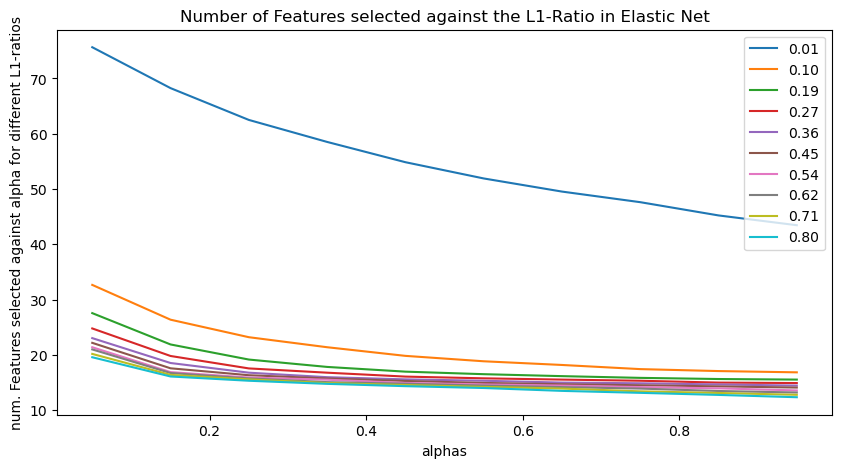

In [1096]:
import matplotlib.pyplot as plt
plt.close()
plt.figure()
numFeatSelected_net[i,k,l]
for k in range(num_ratios):
    plt.plot(alphas,np.mean(numFeatSelected_net[:,k,:],axis=0), label=f"{ratios[k]:.02f}")
plt.xlabel('alphas')
plt.ylabel('num. Features selected against alpha for different L1-ratios')
plt.title('Number of Features selected against the L1-Ratio in Elastic Net')
plt.legend()
plt.show()

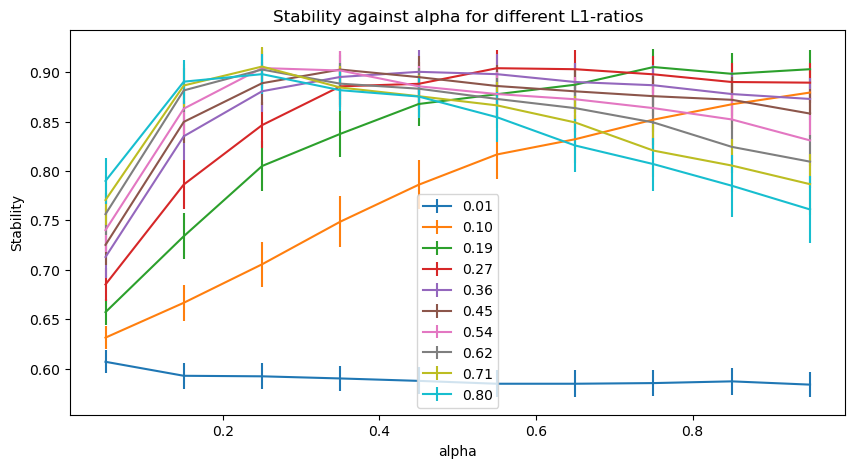

In [1094]:
plt.close()
plt.figure()
for k in range(num_ratios):
    plt.errorbar(alphas, stabilities_net[k,:], yerr=errStab_net[k,:], label=f"{ratios[k]:.02f}")
plt.xlabel('alpha')
plt.ylabel('Stability')
plt.legend()
plt.title('Stability against alpha for different L1-ratios')
plt.show()

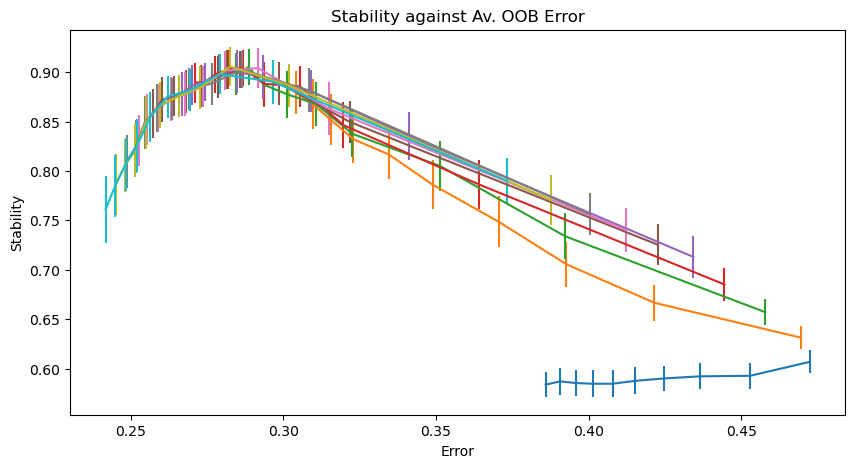

In [1098]:
plt.close()
plt.figure()
for k in range(num_ratios):
    plt.errorbar(meanError_net[k,:],stabilities_net[k,:],yerr=errStab_net[k,:], label=f"{ratios[k]:.02f}")
plt.xlabel('Error')
plt.ylabel('Stability')
plt.title('Stability against Av. OOB Error')
plt.show()

In [ ]:
class FeatureSelector()
    def __init__(self):
        pass
    
    

In [878]:


        self.MAE_VAL = (self.sarimax_result["y_pred"] - self.sarimax_result["y_true"]).iloc[len(self.y_train):].abs().mean()